importing the library for the API and setting the basin of interest (N Atlantic - includes the gulf coast area)

setting the list of cities we are interested in

In [ ]:
# imports for tropycal plots
from tropycal import tracks
import os
import csv
from datetime import datetime
import math
import numpy as np
# imports for spatial correlation analysis
import pandas as pd
import geopandas as gpd
from libpysal.weights import DistanceBand
from shapely.geometry import Point
import ast
from esda.moran import Moran
# imports for location based risk
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
# imports for water temp stuff
import calendar
import seaborn as sns

# the gulf coast cities we were given
target_cities = {
    "New Orleans, USA": (29.9511, -90.0715),
    "Houston, USA": (29.7604, -95.3698),
    "Tampa, USA": (27.9506, -82.4572),
    "Miami, USA": (25.7617, -80.1918),
    "Corpus Christi, USA": (27.8006, -97.3964),
    "Pensacola, USA": (30.4213, -87.2169),
    "Mobile, USA": (30.6954, -88.0399),
    "Galveston, USA": (29.3013, -94.7977),
    "Biloxi, USA": (30.3960, -88.8853),
    "Key West, USA": (24.5551, -81.7800),
    "Veracruz, Mexico": (19.1738, -96.1342),
    "Tampico, Mexico": (22.2553, -97.8686),
    "Campeche, Mexico": (19.8453, -90.5235),
    "Cancún, Mexico": (21.1619, -86.8515),
    "Mérida, Mexico": (20.9674, -89.5926),
    "Ciudad del Carmen, Mexico": (18.6491, -91.8071),
    "Progreso, Mexico": (21.2836, -89.6645),
    "Coatzacoalcos, Mexico": (18.1489, -94.4202),
    "Tuxpan, Mexico": (20.9589, -97.4044),
    "Havana, Cuba": (23.1136, -82.3666),
    "Varadero, Cuba": (23.1547, -81.2546),
    "Cienfuegos, Cuba": (22.1613, -80.4490),
    "Belize City, Belize": (17.5046, -88.1962),
    "George Town, Cayman Islands": (19.2869, -81.3674),
    "Nassau, Bahamas": (25.0343, -77.3963)
}
# just the coords for the cities we were given
just_coords = [
    (29.9511, -90.0715),
    (29.7604, -95.3698),
    (27.9506, -82.4572),
    (25.7617, -80.1918),
    (27.8006, -97.3964),
    (30.4213, -87.2169),
    (30.6954, -88.0399),
    (29.3013, -94.7977),
    (30.3960, -88.8853),
    (24.5551, -81.7800),
    (19.1738, -96.1342),
    (22.2553, -97.8686),
    (19.8453, -90.5235),
    (21.1619, -86.8515),
    (20.9674, -89.5926),
    (18.6491, -91.8071),
    (21.2836, -89.6645),
    (18.1489, -94.4202),
    (20.9589, -97.4044),
    (23.1136, -82.3666),
    (23.1547, -81.2546),
    (22.1613, -80.4490),
    (17.5046, -88.1962),
    (19.2869, -81.3674),
    (25.0343, -77.3963)
]

# the storm types defined in the tropycal documentation (data actually uses more than just these but they arent documented :( )
storm_type_map = {
    "SD": "Subtropical Depression",
    "SS": "Subtropical Storm",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "HU": "Hurricane",
    "TY": "Typhoon",
    "ST": "Super Typhoon",
    "EX": "Extratropical Cyclone",
    "LO": "Low Pressure Disturbance"
}

water_temps = {
    "1988":(23.16,22.5,22.15,23.87,26.42,28.63,29.71,30.36,28.67,27.98,25.62,24.52),
    "1999":(23.25,23.37,23,25.26,26.58,28.53,29.08,29.74,29.26,27.87,25.63,23.99),
    "2000":(23.11,22.93,23.69,24.46,26.8,27.9,29.36,29.22,29.33,27.17,26.16,24.51),
    "2001":(22.81,23,23.43,25.65,25.97,28.44,29.24,29.44,29.13,27.39,25.76,24.7),
    "2002":(22.89,22.97,23.62,25.2,27.13,28.56,29.15,29.7,29.26,28.1,26.19,23.85),
    "2003":(22.13,22.3,23.97,24.02,27.05,28.55,28.61,29.45,29.21,28.2,26.58,23.91),
    "2004":(22.66,22.38,22.9,23.83,25.44,28.36,29.47,29.45,29.33,28.25,26.43,24.54),
    "2005":(23.49,22.62,23.22,24.21,26.28,28.84,29.26,30.18,29.38,28.23,26.25,23.94),
    "2006":(23.51,22.63,23.86,24.83,26.5,28.14,29.46,29.87,29.89,28.04,26.11,24),
    "2007":(23.78,22.61,23.33,24.28,26.52,28.35,29.01,29.61,29.34,28.38,25.82,24.78),
    "2008":(23.4,23.06,23.45,24.57,26.52,29.2,29.08,29.02,28.71,27.73,25.7,23.57),
    "2009":(23.05,23.05,23.27,23.91,26.65,28.41,29.84,30.04,29.84,28.97,26.02,24.28),
    "2010":(21.73,21.43,21.28,22.81,26.53,29.22,29.41,30.17,29.68,27.3,25.28,22.65),
    "2011":(21.5,21.04,22.7,25.05,26.35,28.75,29.41,30.41,29.02,28,25.79,23.96),
    "2012":(23.16,22.69,24.51,25.23,23.98,28.23,29.29,30.01,29.3,28.57,25.74,24.55),
    "2013":(23.58,23.49,22.64,24.35,25.32,28.43,28.51,29.51,28.84,28.06,25.85,24.29),
    "2014":(22.24,22.16,22.55,23.65,25.28,27.88,29.13,30.1,29.47,28.35,25.32,24.31),
    "2015":(23.42,22.75,23.99,25.76,27.09,28.24,29.35,30.08,29.04,28.09,26.67,25.24),
    "2016":(23.72,22.55,23.84,24.61,26.83,29.29,30.23,29.89,29.7,28.92,26.89,25.17),
    "2017":(24.16,23.89,23.76,25.18,26.32,28.57,30,30.21,29.16,28.53,26.63,24.61),
    "2018":(22.94,23.58,23.53,24.52,26.99,28.47,29.84,29.83,29.62,28.68,25.88,24.03),
    "2019":(23.27,23.09,23.95,24.53,26.67,28.86,29.47,30.28,29.83,29.02,26.05,25.17),
    "2020":(24.32,23.49,23.93,25.66,26.48,28.22,29.69,30.35,29.66,28.07,26.76,24.39),
    "2021":(22.66,23.17,23.76,25.34,26.68,28.59,29.01,29.9,29.15,28.71,26.33,25.74),
    "2022":(24.4,22.89,23.3,24.91,27.22,28.58,29.81,29.91,29.53,28.13,26.68,25.43),
    "2023":(23.7,23.47,24.3,25.55,27.36,29.02,30.19,31.1,30.67,29.04,26.77,24.88)
}

# we care about the past 25 years
yearRange = (1998,2023)
#storm needs to hit within {radius} of a city of interest to be relevant (adjust as needed)
radius = 100 #km

not everyone has tropycal setup, so putting the init stuff for the API in its own block that only needs to be run when running methods that talk to tropycal

In [27]:
#set area of interest
basin = tracks.TrackDataset(basin='north_atlantic',include_btk=False)
#test point
currentPoint = target_cities["New Orleans, USA"]
basin.analogs_from_point((currentPoint[0], currentPoint[1]),radius=50)

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (1.71 seconds)
--> Starting to interpolate storms
--> Completed interpolating storms (5.78 seconds)


{'AL011860': np.float64(38.3),
 'AL051869': np.float64(32.9),
 'AL131887': np.float64(42.6),
 'AL041892': np.float64(17.5),
 'AL081893': np.float64(29.9),
 'AL011914': np.float64(21.0),
 'AL061915': np.float64(14.7),
 'AL041936': np.float64(12.4),
 'AL091936': np.float64(39.4),
 'AL041939': np.float64(39.6),
 'AL041947': np.float64(11.6),
 'AL051948': np.float64(8.9),
 'AL011955': np.float64(32.8),
 'AL051955': np.float64(22.2),
 'AL051971': np.float64(9.6),
 'AL111971': np.float64(15.2),
 'AL061975': np.float64(24.7),
 'AL181975': np.float64(8.8),
 'AL151977': np.float64(42.7),
 'AL041979': np.float64(33.5),
 'AL021988': np.float64(3.6),
 'AL071988': np.float64(9.6),
 'AL012001': np.float64(30.4),
 'AL022002': np.float64(19.8),
 'AL102002': np.float64(14.9),
 'AL032003': np.float64(43.7),
 'AL032005': np.float64(28.7),
 'AL122005': np.float64(45.9),
 'AL032020': np.float64(5.5),
 'AL282020': np.float64(10.6),
 'AL032021': np.float64(29.0)}

# A: Visualize storm tracks over the last 25-year period for the Gulf Coast region.

### For each city of interest, pull all storms of at least Cat1 that pass within the set radius (currently 50km) within the defined 30yr period

### Print the IDs for each storm and plot their courses and dump those plots into the specified folder

In [ ]:
# Define the folder path
output_folder = "/Users/andrew/COSC-3337/hurricanePlots"  # Change this to your desired folder path
# output_folder = "C:\Users\Andrew\Documents\COSC-3337\hurricanePlots"
os.makedirs(output_folder, exist_ok=True)

# stormLog = {}

# plot each city and its storms on a separate map (to make easier to read)
for city,coords in target_cities.items():
    print("{} is at {}".format(city, coords))

    # Set the full path for the plot image file
    savePathCity = city.split(",")
    save_path = os.path.join(output_folder, savePathCity[0]+".png")

    storms = basin.analogs_from_point(coords,radius=radius,year_range=yearRange,thresh={'v_min':33})
    
    if not storms:
        print("No hurricanes hit within 50km of {} between 1990 and 2020\n".format(savePathCity[0]))
    else:
        print("Storm log for {}: {}\n".format(savePathCity[0], storms))
        #thresh is min sustained wind of 33kt => 62 kmph
        basin.plot_analogs_from_point(coords,radius=radius,domain='north_atlantic', prop={'plot_names':True},year_range=yearRange,thresh={'v_min':33},save_path=save_path)



#plot all hurricanes (at least tropical storm) that hit any of the cities we care about in the last 25 years
#thresh is min sustained wind of 33kt => 62 kmph

#This is the list of storms that meet the criteria we're going to be plotting in the next line
storms = basin.analogs_from_shape(just_coords,year_range=yearRange,thresh={'v_min':33})
print(storms)
print(len(storms))

#domain is used to set the focus of the plot. would probably help to set a custom domain since none of the presets are the gulf coast area

save_path = os.path.join(output_folder, "gulf_coast_region.png")
basin.plot_storms(storms,domain='north_atlantic', prop={'plot_names':True},save_path=save_path) #dots

# basin.plot_storms(storms[:10],domain='north_atlantic', prop={'dots':False,'linecolor':'category','linewidth':2,'plot_names':True},save_path=save_path) #lines

    

### Creates CSV summary of the storms of interest

In [49]:
""" 
Calculate the Hversine distance between two coordinates (used to calc distance between two points on a sphere)
"""
def haversine_distance(coord1, coord2):
    # Calculate the great-circle distance between two points using the Haversine formula
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return R * c

"""
Compares the list of target cities and the tracks for each storm of interest and lists where each storm enters the impact radius of a city (also lists the type of storm it is when it is closest to the city)

storm_track: array of coords that represents the course the storm took
storm_ratings: array of two-letter abreviations that show the storm's rating at each coordinate point along its track
target_cities: list of city names and coordinates we're interested in in the Gulf Coast region
radius: how close a storm needs to get to a city to "impact" it
"""
def find_impacted_cities(storm_track, storm_ratings, target_cities, radius=100):
    
    result_str = ""
    
    # Loop through each city and its coordinates
    for city, city_coord in target_cities.items():
        closest_distance = float('inf')
        closest_index = -1
        
        # Loop through each point in the storm track to find the closest one
        for i, track_coord in enumerate(storm_track):
            distance = haversine_distance(city_coord, track_coord)
            
            # Update closest distance and index if this point is closer
            if distance < closest_distance:
                closest_distance = distance
                closest_index = i
        
        # If the closest point is within the specified radius, add to the result string
        if closest_distance <= radius:
            rating = storm_ratings[closest_index]  # Get the storm's rating at this closest track point
            try:
                rating = storm_type_map[rating]
            except KeyError:
                pass
            result_str += f"hit {city} as {rating}, "
    
    # Remove the trailing comma and space
    return result_str.rstrip(", ")

"""
checks if the csv file is blank or not (the file is wiped and completely rewritten each time)
"""
def is_file_blank(filename):
    return os.path.isfile(filename) and os.stat(filename).st_size == 0

"""
Takes a storm and pulls its data from tropycal and adds the information we care about to the csv file

// takes id, name, year, type, lat, lon, vmax, mslp from tropycal //

processes the lat/lon arrays to find impacted cities (lists storm rating for each city too)
"""
def append_hurricane_summary_to_csv(data, filename='hurricane_summary.csv'):
    # Define the critical fields to include in the CSV
    critical_fields = ['id', 'name', 'year', 'type', 'lat', 'lon', 'vmax', 'mslp']
    
    # Extract values for each critical field except time
    data_to_write = {field: data[field] for field in critical_fields if field in data}
    
    # Get start_time and end_time from the time list
    start_time = data['time'][0].isoformat() if isinstance(data['time'][0], datetime) else data['time'][0]
    end_time = data['time'][-1].isoformat() if isinstance(data['time'][-1], datetime) else data['time'][-1]

    # Find the closest coordinate in the data to any coordinate in just_coords
    data_coords = list(zip(data['lat'], data['lon']))
    impacted_cities = find_impacted_cities(data_coords, data['type'], target_cities)

    storm_track = list(zip(data['lat'], data['lon'], data['type']))

    
    # Check if file exists to decide if headers are needed (also grabs if file is just blank)
    file_exists = os.path.isfile(filename)
    file_is_blank = is_file_blank(filename)
    
    # Write data to CSV
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # If the file is new, add headers
        if not file_exists:
            headers = ['id', 'name', 'year', 'start_time', 'end_time', 'init_lat', 'init_lon', 'vmax', 'mslp','cities_impacted', 'storm_track']
            writer.writerow(headers)
        # If file is not new but has been blanked, add headers
        elif file_is_blank:
            headers = ['id', 'name', 'year', 'start_time', 'end_time', 'init_lat', 'init_lon', 'vmax', 'mslp','cities_impacted', 'storm_track']
            writer.writerow(headers)
        
        # Prepare a row with the required data
        row = [
            data['id'],
            data['name'],
            data['year'],
            start_time,
            end_time,
            data['lat'][0],   # Using the initial latitude
            data['lon'][0],   # Using the initial longitude
            max(data['vmax']), # Maximum vmax during the period
            min(data['mslp']),  # Minimum mslp during the period
            impacted_cities,
            storm_track
        ]
        
        writer.writerow(row)

storms = basin.analogs_from_shape(just_coords,year_range=yearRange,thresh={'v_min':33})

logOfStormDicts = []
#clear csv file before writing everything to it
with open('hurricane_summary.csv', 'w') as file:
    pass

#write each storm to the csv file, writes the headers the first time and just appends every time after
for eachStorm in storms:
    stormOfInterest = basin.get_storm(eachStorm)
    # print(stormOfInterest.to_dict())
    print(stormOfInterest)
    logOfStormDicts.append(stormOfInterest.to_dict()) #prob dont need
    
    append_hurricane_summary_to_csv(stormOfInterest.to_dict())



<tropycal.tracks.Storm>
Storm Summary:
    Maximum Wind:      60 knots
    Minimum Pressure:  1000 hPa
    Start Time:        0600 UTC 21 August 1998
    End Time:          0000 UTC 24 August 1998

Variables:
    time        (datetime) [1998-08-21 06:00:00 .... 1998-08-24 00:00:00]
    extra_obs   (int64) [0 .... 0]
    special     (str) [ .... ]
    type        (str) [TD .... TD]
    lat         (float64) [25.3 .... 29.4]
    lon         (float64) [-92.3 .... -101.2]
    vmax        (int64) [25 .... 20]
    mslp        (int64) [1008 .... 1008]
    wmo_basin   (str) [north_atlantic .... north_atlantic]

More Information:
    id:              AL031998
    operational_id:  AL031998
    name:            CHARLEY
    year:            1998
    season:          1998
    basin:           north_atlantic
    source_info:     NHC Hurricane Database
    source:          hurdat
    ace:             0.8
    realtime:        False
    invest:          False
    subset:          False
<tropycal.tracks

# B: Identify Common Patterns and Trends

# C: Make a report after performing statistical analysis of track frequency, intensity, motion vectors and duration.

In [ ]:
# Import the csv file and reformat to better suit needs
data = pd.read_csv('hurricane_summary.csv')

expanded_data = []
for _, row in data.iterrows():
    storm_id = row['id']
    name = row['name']
    year = row['year']
    
    # Convert the storm_track column from string to list
    storm_track = ast.literal_eval(row['storm_track'])
    
    for point in storm_track:
        lat, lon, rating = point
        expanded_data.append({
            'storm_id': storm_id,
            'name': name,
            'year': year,
            'latitude': lat,
            'longitude': lon,
            'rating': rating
        })
expanded_storm_data = pd.DataFrame(expanded_data)

# Going to use GeoData for spatial analysis, so need to convert to geodataframe
geometry = [Point(xy) for xy in zip(expanded_storm_data['longitude'], expanded_storm_data['latitude'])]
geo_storm_data = gpd.GeoDataFrame(expanded_storm_data, geometry=geometry)

# distance threshold to define neighbors
threshold_distance = 500000 # in meters (500km)
# Calculate the spatial weights using DistanceBand
# This will create a spatial weight matrix based on distance threshold
weights = DistanceBand.from_dataframe(geo_storm_data, threshold=threshold_distance, silence_warnings=True)

geo_storm_data['frequency'] = geo_storm_data.groupby(['latitude', 'longitude'])['storm_id'].transform('count')

# Calculate Moran's I for spatial autocorrelation on frequency
# Results interpretation:
# - Moran's I close to +1 indicates clustering, while -1 indicates dispersion
# - p-value below 0.05 suggests significant spatial autocorrelation
moran = Moran(geo_storm_data['frequency'], weights)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}") 





Moran's I: -0.0006316158004260504, p-value: 0.001


#### Global spatial correlation analysis with frequency in the region as the variable to study
currently returns: Moran's I: -0.0006316158004260504, p-value: 0.001 

indicates dispersion of storms with high frequency locations spread apart (the closer to -1, the more severe this dispersion)

(if goal is location-based risk prediction, consider doing regional spatial correlations to better understand localized risk)

#### Positive Spatial Autocorrelation:
- High values cluster together (e.g., regions with high hurricane frequencies tend to be near other high-frequency regions).
- Low values also cluster together (e.g., areas with few or no hurricanes tend to be near each other).
- Interpretation: There are “hotspots” where hurricanes frequently occur, as well as “cold spots” with fewer hurricanes.
#### Negative Spatial Autocorrelation:
- High and low values are dispersed, meaning high-frequency regions are likely to be near low-frequency regions, and vice versa.
- Interpretation: Hurricane impacts are more spread out, showing an alternating pattern of high- and low-frequency regions without distinct clusters.
#### Statistical Significance:
- A significant p-value (usually < 0.05) confirms that the observed spatial pattern is unlikely to be due to random chance.
- If the spatial autocorrelation is statistically significant, you can confidently say that there is a meaningful spatial structure in the hurricane data.

storm_type_map = {
    "SD": "Subtropical Depression",
    "SS": "Subtropical Storm",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "HU": "Hurricane",
    "TY": "Typhoon",
    "ST": "Super Typhoon",
    "EX": "Extratropical Cyclone",
    "LO": "Low Pressure Disturbance"
}

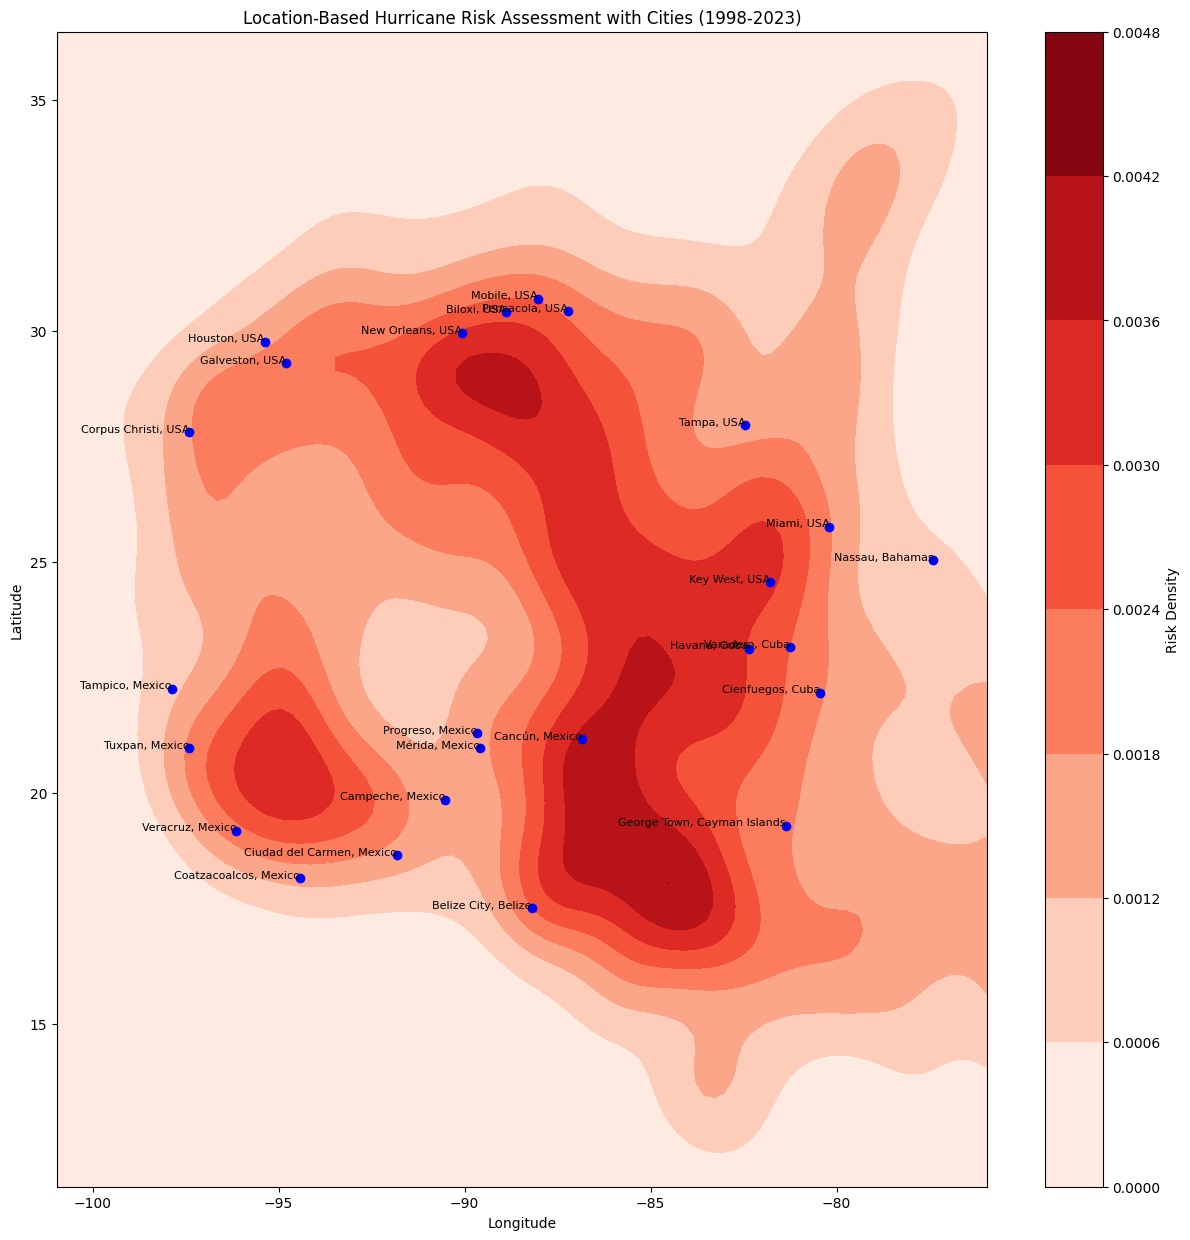

In [ ]:
start_year = 1998
end_year = 2023
#2003, 2008, 2013, 2018, 2023

data = pd.read_csv('hurricane_summary.csv')

data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]

expanded_data = []
severity_weights = {'SD':0.5, 'SS':0.5, 'TD': 0.5, 'TS': 1, 'HU': 3, 'TY':3, 'ST':4, 'EX':0.5, 'LO':0.5}  
for _, row in data.iterrows():
    storm_id = row['id']
    name = row['name']
    year = row['year']
    
    # Convert the storm_track from string to list of tuples
    storm_track = ast.literal_eval(row['storm_track'])
    
    # Expand each coordinate point in the storm track
    for point in storm_track:
        lat, lon, severity = point
        weight = severity_weights.get(severity, 1)  # Default weight of 1 if severity is unknown
        expanded_data.append({
            'storm_id': storm_id,
            'name': name,
            'year': year,
            'latitude': lat,
            'longitude': lon,
            'severity': severity,
            'weight': weight
        })

expanded_storm_data = pd.DataFrame(expanded_data)
# Extract latitude and longitude as coordinates
coords = expanded_storm_data[['longitude', 'latitude']].values
weights = expanded_storm_data['weight'].values

# Define bandwidth and initialize KDE
bandwidth = 1  # Adjust this bandwidth for your desired spatial resolution
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde.fit(coords, sample_weight=weights)

# Calculate the average latitude and longitude of the cities
average_lat = np.mean([coord[0] for coord in target_cities.values()])
average_lon = np.mean([coord[1] for coord in target_cities.values()])

# Define a grid range based on the average coordinates
lat_range = 25  # Define a latitude range around the average point
lon_range = 25  # Define a longitude range around the average point
x = np.linspace(average_lon - lon_range / 2, average_lon + lon_range / 2, 100)  # Longitude range
y = np.linspace(average_lat - lat_range / 2, average_lat + lat_range / 2, 100)  # Latitude range
X, Y = np.meshgrid(x, y)
grid_coords = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE on the grid
Z = np.exp(kde.score_samples(grid_coords)).reshape(X.shape)

# Plotting the KDE heatmap with city coordinates
plt.figure(figsize=(15, 15))
plt.contourf(X, Y, Z, cmap="Reds")
plt.colorbar(label="Risk Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Location-Based Hurricane Risk Assessment with Cities ({}-{})".format(start_year, end_year))

# Overlay city points and labels
for city, (lat, lon) in target_cities.items():
    plt.plot(lon, lat, 'bo')  # Plot city locations
    plt.text(lon, lat, city, fontsize=8, ha='right')  # Label cities

plt.show()


City by City risk assessment

In [44]:
# Calculate risk score for each city
city_risk_scores = {}

for city, (lat, lon) in target_cities.items():
    city_coord = np.array([[lon, lat]])
    risk_score = np.exp(kde.score_samples(city_coord))[0]  # Density value for the city's location
    city_risk_scores[city] = risk_score

# Normalize the risk scores
max_risk = max(city_risk_scores.values())
min_risk = min(city_risk_scores.values())

# Calculate normalized and percentage scores
city_risk_normalized = {city: (score - min_risk) / (max_risk - min_risk) for city, score in city_risk_scores.items()}
city_risk_percentage = {city: (score / max_risk) * 100 for city, score in city_risk_scores.items()}

# Display results with aligned columns
print("City-by-City Hurricane Risk Assessment:")
print(f"{'City':<28} {'Raw Risk Score':<15} {'Normalized Score':<18} {'Percentage of Max Risk'}")
print("-" * 75)
for city in city_risk_scores:
    raw_score = city_risk_scores[city]
    normalized_score = city_risk_normalized[city]
    percentage_score = city_risk_percentage[city]
    print(f"{city:<28} {raw_score:<15.4f} {normalized_score:<18.4f} {percentage_score:<.2f}%")

City-by-City Hurricane Risk Assessment:
City                         Raw Risk Score  Normalized Score   Percentage of Max Risk
---------------------------------------------------------------------------
New Orleans, USA             0.0031          0.7775             82.36%
Houston, USA                 0.0017          0.3024             44.69%
Tampa, USA                   0.0016          0.2741             42.44%
Miami, USA                   0.0018          0.3589             49.17%
Corpus Christi, USA          0.0017          0.3295             46.84%
Pensacola, USA               0.0023          0.5005             60.40%
Mobile, USA                  0.0023          0.5276             62.54%
Galveston, USA               0.0022          0.4727             58.19%
Biloxi, USA                  0.0028          0.6716             73.97%
Key West, USA                0.0031          0.7849             82.94%
Veracruz, Mexico             0.0022          0.4781             58.62%
Tampico, Mexico 

In [57]:
hurricane_data = pd.read_csv('hurricane_summary.csv')

# Extract start month and assign relevant water temperature
hurricane_data['start_month'] = hurricane_data['start_time'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S').month
)
hurricane_data['water_temp'] = hurricane_data.apply(
    lambda row: water_temps.get(str(row['year']), [None] * 12)[row['start_month'] - 1], axis=1
)

# Group by month to calculate average temperature and hurricane count
monthly_stats = hurricane_data.groupby('start_month').agg(
    average_temp=('water_temp', 'mean'),
    hurricane_count=('id', 'size')  # Counts hurricanes in each month
)

# Display results with month names
print("Average Water Temperature and Hurricane Count for Each Month with Hurricanes:")
for month, row in monthly_stats.iterrows():
    month_name = calendar.month_name[month+1]
    avg_temp = row['average_temp']
    hurricane_count = row['hurricane_count']
    print(f"{month_name}: Avg Water Temp = {avg_temp:.2f} °C, Num Hurricanes: {hurricane_count}")

Average Water Temperature and Hurricane Count for Each Month with Hurricanes:
June: Avg Water Temp = 26.85 °C, Num Hurricanes: 4.0
July: Avg Water Temp = 28.63 °C, Num Hurricanes: 17.0
August: Avg Water Temp = 29.33 °C, Num Hurricanes: 10.0
September: Avg Water Temp = 29.84 °C, Num Hurricanes: 32.0
October: Avg Water Temp = 29.31 °C, Num Hurricanes: 32.0
November: Avg Water Temp = 28.10 °C, Num Hurricanes: 18.0
December: Avg Water Temp = 26.02 °C, Num Hurricanes: 1.0


In [ ]:
# Group by month to calculate average temperature and hurricane count
monthly_stats = hurricane_data.groupby('start_month').agg(
    average_temp=('water_temp', 'mean'),
    hurricane_count=('id', 'size')
).reset_index()

# Box Plot: Distribution of Water Temperatures with Hurricane Counts by Month
plt.figure(figsize=(12, 6))
sns.boxplot(data=hurricane_data, x='start_month', y='water_temp', color="skyblue")
sns.swarmplot(data=monthly_stats, x='start_month', y='average_temp', size=8, color="orange", label="Avg Temp")
plt.xticks(range(12), [calendar.month_abbr[i+1] for i in range(12)])
plt.xlabel("Month")
plt.ylabel("Water Temperature (°C)")
plt.title("Water Temperature Distribution by Month with Average Monthly Temp Overlay")
plt.legend()
plt.show()

# Line Graph with Dual Y-Axes: Average Temperature and Hurricane Count by Month
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average temperature on primary y-axis
ax1.plot(monthly_stats['start_month'], monthly_stats['average_temp'], color="orange", label="Avg Water Temp")
ax1.set_xlabel("Month")
ax1.set_ylabel("Average Water Temperature (°C)", color="orange")
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
ax1.tick_params(axis="y", labelcolor="orange")

# Plot hurricane count on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_stats['start_month'], monthly_stats['hurricane_count'], color="blue", label="Hurricane Count")
ax2.set_ylabel("Hurricane Count", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add title and legends
plt.title("Average Water Temperature and Hurricane Count by Month")
fig.tight_layout()
plt.show()